# Modelo de Kermack McKendrick

In [1]:
include("Taylor.jl")
using ADT
using PyPlot

Las ecuaciones diferenciales que rigen el modelo para una especie son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

En este modelo NO tomamos en cuenta los nacimientos y muertes, así que para una población fija se tiene que $ N = S(t) + I(t) + R(t)$ en todo tiempo.

In [2]:
function coefs_1(gamma, beta, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) # F1 = -b*S*I
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) # F2 = g*I

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1 (generic function with 2 methods)

Error absoluto

In [3]:
eps_abs = 1e-20

1.0e-20

In [4]:
function paso(a::Taylor, p = 40)
    
    while p != 0 && a.pol[p] == 0
       p = p-1;
    end
    
    h = 0.5*(eps_abs/abs(a.pol[p]))^(1/p)
end

paso (generic function with 2 methods)

In [5]:
function ev_horner{T<:Number}(a::Taylor,t0::T)
    
    n = gradomax(a)
    x1 = a.pol[n]
    
    for k = 1:n-1
        x1 = a.pol[n-k] + x1*t0
    end
    return x1
end

ev_horner (generic function with 1 method)

In [6]:
function integrador_kermack(N, I0, R0, t0, tf, gamma, beta)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_1(gamma, beta, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    return t,s,i,r
end

integrador_kermack (generic function with 1 method)

In [7]:
N = 1.
infectados_iniciales = N/1000
recuperados_iniciales = 0.0
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta);

  0.978986 seconds (8.38 M allocations: 154.625 MB, 1.98% gc time)


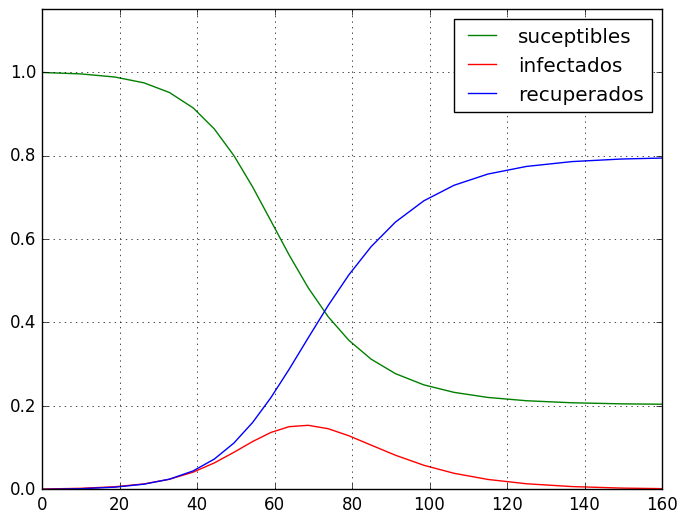

In [9]:
plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
axis([0,160,0,1.15])
grid()
legend()
show()

Ahora hagamos un diagrama fase de esto, donde no esperamos ningún comportamiento peculiar.

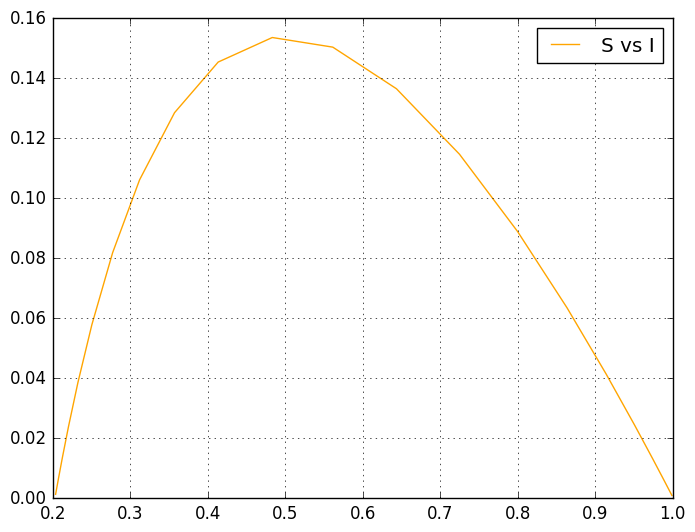

In [10]:
plot(s,i, color = "orange", label = "S vs I")
legend()
grid()

Va con reincidencia

In [11]:
function coefs_1_re(gamma, beta, phi, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    F3(R) = phi*R
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) + F3(Tr)# F1 = -b*S*I
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) - F3(Tr) # F2 = g*I

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1_re (generic function with 2 methods)

In [203]:
function integrador_kermack_re(N, I0, R0, t0, tf, gamma, beta, phi)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    n_iteraciones = 1
    while t0 < tf && n_iteraciones < 500
        
        S,I,R = coefs_1_re(gamma, beta, phi, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
        n_iteraciones += 1
    end
    return t,s,i,r
end

integrador_kermack_re (generic function with 1 method)

In [274]:
N = 1.
t_inicial = 0.
t_final = 1400.
beta = .5
gamma = .25
phi = 0.005
infectados_iniciales = N/1000
recuperados_iniciales = 0.

@time t,s,i,r = integrador_kermack_re(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta, phi);
length(t)

  1.229763 seconds (40.69 M allocations: 669.806 MB, 6.52% gc time)


115

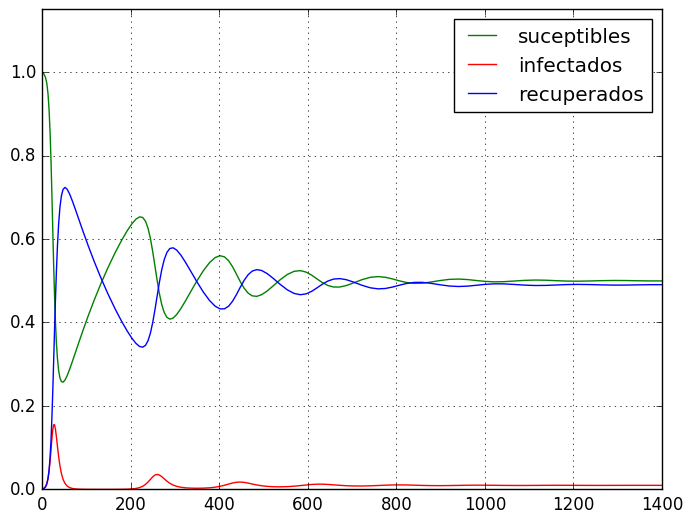

In [275]:
plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
axis([0,t_final,0,1.15])
grid()
legend()
show()

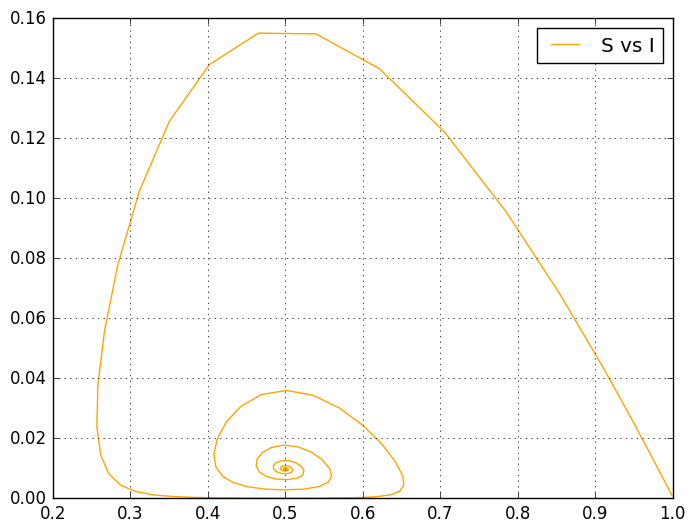

In [285]:
plot(s,i, color = "orange", label = "S vs I")
legend()
grid()

# Model SIRS con Nacimientos y Muertes

Ahora consideraremos que hay una taza de natalidad $\mu$, la cual asumiremos que es igual a la taza de mortalidad. Además, consideraremos una tasa de reincidencia f de la población recuperada. De este modo, la población presenta el siguiente flujo:
$\mathcal{S} \rightarrow \mathcal{I} \rightarrow \mathcal{R} \rightarrow \mathcal{S}$, por lo que el modelo se denomina **SIRS** (donde además, consideramos los nacimientos y muertes). Entonces, el modelo queda de la siguiemte manera:

\begin{array}{rcl} 
\frac{dS}{dt}  & = & - \frac{\beta S I}{N} + \mu (N - S) + f R  \\ 
\frac{dI}{dt} & = & \frac{\beta S I}{N} - \gamma I - \mu I  \\
\frac{dR}{dt} & = & \gamma I - \mu R - f R \\
\end{array}

Ahora, realizaremos la integración de este sistema de ecuaciones. Sólo requeriremos modificar la función de coeficientes para considerar los términos adicionales y, además, modificar el integrador para que considere los parámetros adicionales.

In [9]:
function coefs_SIRS(γ,β,μ,f,S_0,I_0,R_0,n=50)
    N=S_0+I_0+R_0
    
    s=[S_0]
    i=[I_0]
    r=[R_0]  #inicializar arrays 
    
    F1(S,I,R) = -(β/N)*S*I + μ*(I+R)+f*R #N-S=I+R pues N=I+R+S 
    F2(S,I) = (β/N)*S*I -γ*I -μ*I
    F3(I,R) = γ*I-μ*R-f*R
    
    f1=Taylor(0) #inicializamos f's pues las variables definidas en el for son locales
    f2=Taylor(0)
    f3=Taylor(0)
    
    for k in 1:n
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)

        f1=F1(Ts,Ti,Tr)
        f2=F2(Ts,Ti)
        f3=F3(Ti,Tr)
        
        S_0 = f1.pol[k]/k
        I_0 = f2.pol[k]/k
        R_0 = f3.pol[k]/k
        
        push!(s,S_0)
        push!(r,R_0)
        push!(i,I_0)
           
    end
    
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    
    return s,i,r
end

coefs_SIRS (generic function with 2 methods)

In [10]:
"""
Esta función integra la ecuación diferencial del modelo de Kermack-McKendrick SIRS discurito previamente. Sus parámetros son:
integrador_kermack(N=población total,I0=infectados inicialmente,t0=tiempo inicial,tf=tiempo final,γ=tasa de recuperación,
β=tasa de infección,μ=tasa de natalidad,f=tasa,n=numero de términos en los pols. de Taylor). 
Se consideran nacimientos y muertes, pero se asume que la tasa de natalidad es igual que la de mortalidad. Con esto,
la población total se mantiene constante
"""
function integrador_kermack_SIRS(N, I0, R0, t0, tf, gamma, beta,mu,f,n=50)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_SIRS(gamma, beta,mu,f, S0, I0, R0,n)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    
    return t,s,i,r
end

integrador_kermack_SIRS (generic function with 2 methods)

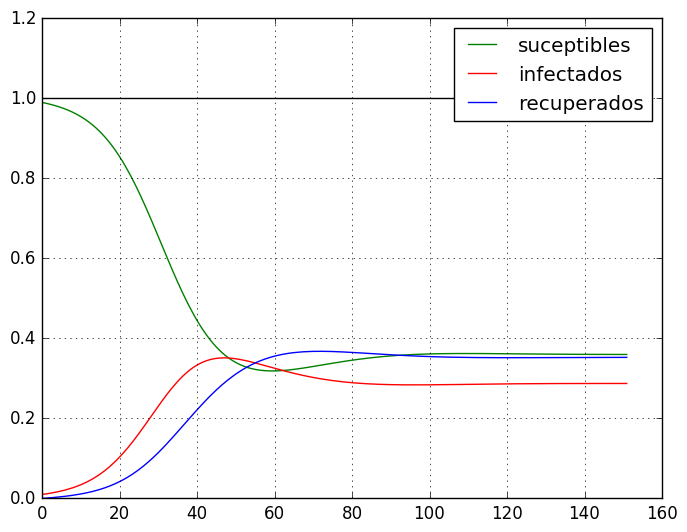

  2.621726 seconds (88.02 M allocations: 1.425 GB, 4.26% gc time)


In [41]:
N = 1.
I0 = N/100
R0 = 0.
S0 = N-I0-R0
ti = 0.
tf = 150.
beta = 0.2
gamma = 0.07
mu = 0.002
f = 0.055

@time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta ,mu,f);

using PyPlot

plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
plot(t,r+i+s,color="black")
grid()
legend()
show()

  2.219621 seconds (74.16 M allocations: 1.201 GB, 4.95% gc time)
  2.046258 seconds (70.70 M allocations: 1.145 GB, 4.48% gc time)
  2.023541 seconds (69.31 M allocations: 1.122 GB, 4.65% gc time)
  2.008892 seconds (69.31 M allocations: 1.122 GB, 4.47% gc time)
  2.278177 seconds (70.00 M allocations: 1.134 GB, 4.30% gc time)


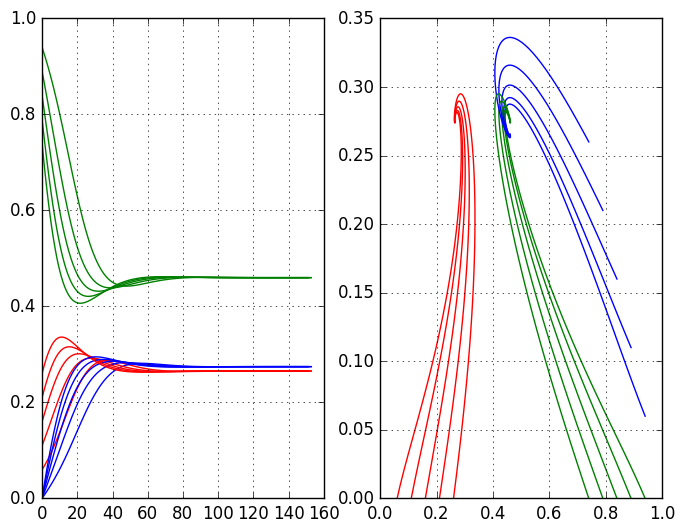

In [47]:
p = 5

for j in 1:p
    
    N = 1.
    I0 = N/100+0.05*j
    R0 = 0.
    S0 = N-I0-R0
    ti = 0.
    tf = 150.
    beta = 0.2
    gamma = 0.09
    mu = 0.002
    f = 0.085


    @time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta, mu, f);

    subplot(1,2,1)
    plot(t,s, color = "green", label = "suceptibles")
    plot(t,i, color = "red", label = "infectados")
    plot(t,r, color = "blue", label = "recuperados")
    grid()

    subplot(1,2,2)
    plot(s,i, color="blue")
    plot(s,r,color="green")
    plot(i,r,color="red")
    grid()
end

# Para K especies (K=3)

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.


$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$

In [13]:
eps_abs = 1e-50

1.0e-50

In [14]:
function coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fr = F2(gamma[i], Ti[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3 (generic function with 2 methods)

In [15]:
function k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
    end
    return t,s,i,r
end

k_3 (generic function with 1 method)

In [66]:
N1 = .5
N2 = .3
N3 = .2
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 250.
;

In [67]:
beta = rand(3,3)/3
gamma = rand(3)/8
;

In [68]:
t3, s3, i3, r3 = k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma, beta);

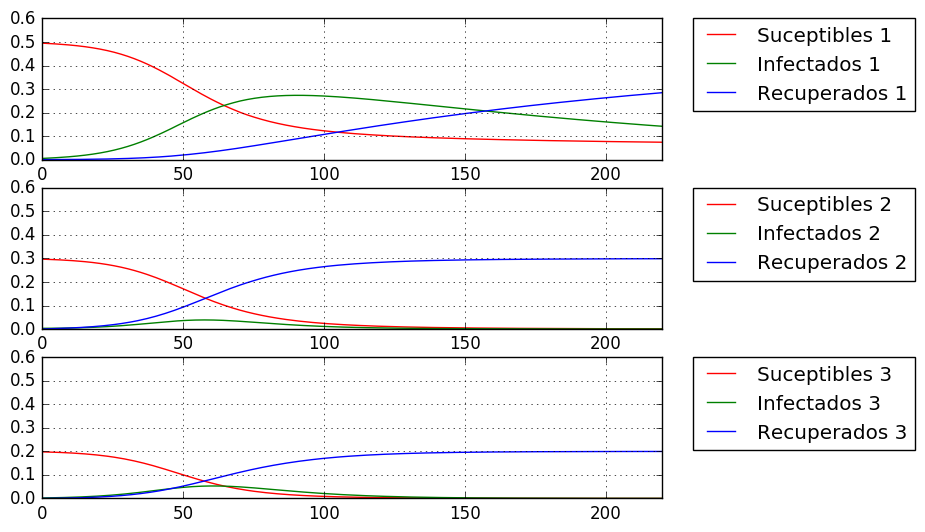

In [70]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axis([0, 220, 0, 0.6])
    grid()
end

In [20]:
suma = 0
for k = 1:3
    suma += s3[k]+i3[k]+r3[k]
end
dump(suma)

Array(Float64,(91,)) [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]


Como vemos, la población total $N$ se mantiene constante.

Ahora que nuestro integrador funciona, implementaremos un factor de reincidencia $\phi$ para cada una de las especies.

$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3 + \phi_i R_i$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i - \phi_i R_i$$

Modificamos un poco nuestro código anterior para lograrlo. Definimos una función para calcular los coeficientes y nuestro integrador.

In [286]:
function coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    F3(phi_i,R) = phi_i*R
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fs += F3(phi[i],Tr[i])
            fr = F2(gamma[i], Ti[i])-F3(phi[i],Tr[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3_reincidencia (generic function with 2 methods)

In [354]:
function k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta, phi)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    n_iteracion = 1
    
    while t0 < tf && n_iteracion < 2000
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
        n_iteracion += 1
    end
    return t,s,i,r
end

k_3_reincidencia (generic function with 1 method)

Definimos nuestras matrices de coeficientes. $\beta_{ij}$ es la matriz de coeficientes de transmisión, $\gamma_i$ la de coeficientes de recuperación (con $1/\gamma_i$ el tiempo promedio de recuperación) y $\phi_i$ la matriz de reincidencia o re-contagio. Al no tener datos experimentales, tomamos valores que están de acuerdo con la teoría.

In [288]:
phi1 = ([0.011980782470983145,0.0122242866833574,0.12049916741165438])
gamma1 = ([0.0920466,0.0690204,0.0427661])
beta1 = [0.138933 0.0147811 0.0747647; 0.0243735 0.116977 0.0574383; 0.183494 0.109088 0.283322]
;

In [411]:
beta = rand(3,3)/3
gamma = rand(3)/20
phi = rand(3)/100
;

In [412]:
N1 = 1.
N2 = 1.
N3 = 1.
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 700.
;

In [415]:
@time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma1, beta1, phi);
length(t3)

  2.852629 seconds (83.09 M allocations: 1.343 GB, 6.44% gc time)


56

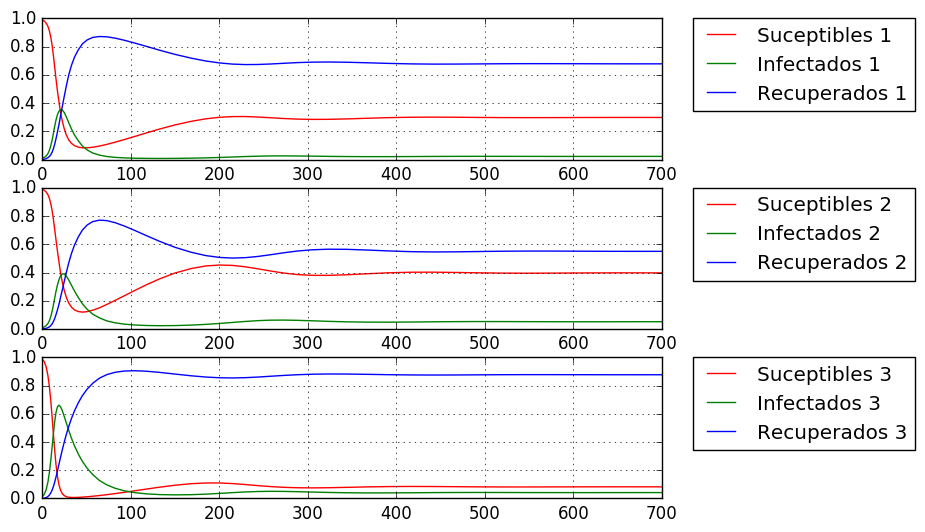

In [416]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end

Muchos diagramas de fase a lo tonto.

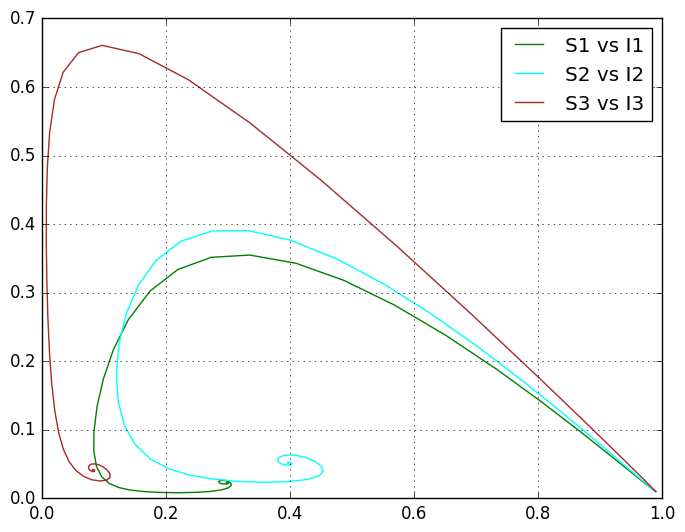

In [417]:
plot(s3[1],i3[1], color = "green", label = "S1 vs I1")
# plot(s3[1],i3[2], color = "red", label = "S1 vs I2")
# plot(s3[1],i3[3], color = "blue", label = "S1 vs I3")
plot(s3[2],i3[2], color = "cyan", label = "S2 vs I2")
# plot(s3[2],i3[3], color = "magenta", label = "S2 vs I3")
plot(s3[3],i3[3], color = "brown", label = "S3 vs I3")
# plot(r3[1],i3[1], color = "peru", label = "R3 vs I3")
legend()
grid()

Ahora busquemos alguna bifurcación variando I0_1. Declaramos de nuevo nuestros parámetros.

In [420]:
N1 = 1.
N2 = .2
N3 = .1
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 250.
;

  0.802572 seconds (25.68 M allocations: 425.093 MB, 7.28% gc time)
  0.787504 seconds (25.68 M allocations: 425.093 MB, 7.10% gc time)
  0.782211 seconds (25.68 M allocations: 425.093 MB, 6.73% gc time)
  0.829890 seconds (25.68 M allocations: 425.093 MB, 6.69% gc time)
  0.998233 seconds (25.68 M allocations: 425.093 MB, 5.38% gc time)
  1.001408 seconds (25.68 M allocations: 425.093 MB, 5.63% gc time)
  0.999681 seconds (25.68 M allocations: 425.093 MB, 5.45% gc time)
  1.061408 seconds (27.19 M allocations: 450.098 MB, 5.66% gc time)
  1.118013 seconds (28.70 M allocations: 475.103 MB, 5.38% gc time)
  1.182846 seconds (30.21 M allocations: 500.108 MB, 5.59% gc time)
  1.181954 seconds (30.21 M allocations: 500.108 MB, 5.61% gc time)
  1.241156 seconds (31.72 M allocations: 525.114 MB, 5.62% gc time)
  1.246059 seconds (31.72 M allocations: 525.114 MB, 5.56% gc time)
  1.296989 seconds (33.23 M allocations: 550.119 MB, 5.64% gc time)
  1.303311 seconds (33.23 M allocations: 550.119

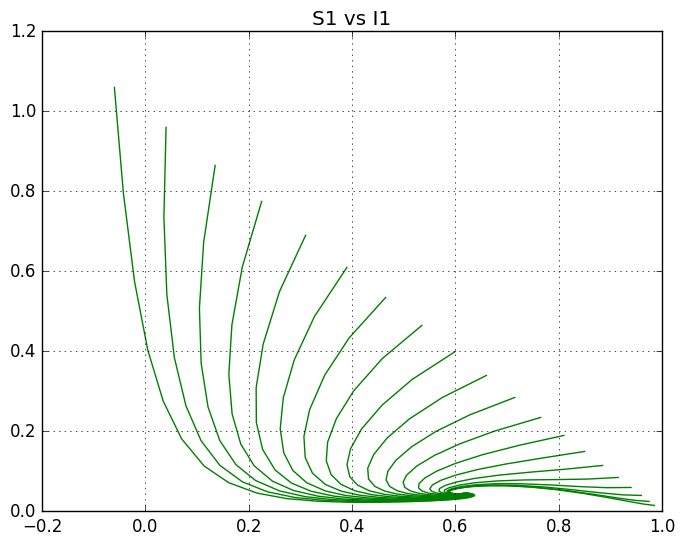

PyObject <matplotlib.text.Text object at 0x0000000027C3ADD8>

In [421]:
for i in 1:20
    I0_1 += 0.005*i
    @time t3, s3, i3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma1, beta, phi1);    
    plot(s3[1],i3[1], color = "green")
end
grid()
title("S1 vs I1")

Lo de abajo es un ejercicio de metaprogramming, no lo borren pls

In [32]:
for k = 1:3
    
    hola = symbol(string("hola",k))
    @eval ($hola) = ($k)
end